In [131]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [133]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [134]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#Data Processing, splitting data to categorical and numberical ones.

In [ ]:
categorical_features = ['Sex', 'Embarked']
numerical_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [ ]:
print("Shape of train dataset:", train.shape)
print("Shape of test dataset:", test.shape)

In [ ]:
# Assuming train_df and test_df are loaded correctly
full = pd.concat([train, test], ignore_index=True)
full.describe()

In [ ]:
full.info()

In [ ]:
#Data visulization for analysis later
sns.barplot(data=train,x='Pclass',y='Survived')

In [ ]:
sns.barplot(data=train,x='Sex',y='Survived')

In [ ]:
sns.barplot(data=train,x='Embarked',y='Survived')

In [ ]:
# Group by 'Embarked' and 'Survived', and calculate value counts
s = full.groupby('Embarked')['Survived'].value_counts().to_frame()

# Calculate the proportion of survivors by 'Embarked' port
s1 = s / s.groupby(level=0).sum()

# Merge 's' and 's1' DataFrames
result = pd.merge(s, s1, left_index=True, right_index=True)

# Print the result
print(result)

In [ ]:
# Create a FacetGrid
ageFact = sns.FacetGrid(train, hue='Survived', aspect=3)

# Map a KDE plot for the 'Fare' feature
ageFact.map(sns.kdeplot, 'Fare', fill=True)

# Set x-axis limits
ageFact.set(xlim=(0, 150))

# Add a legend
ageFact.add_legend()

In [ ]:
full['Fare'] = full['Fare'].map(lambda x: np.log(x + 1))
sns.displot(full['Fare'], kde=True, bins=30, color='blue')

In [ ]:
#Fill the missing value
full['Cabin'] = full['Cabin'].fillna('U')

In [ ]:
missing_embarked = full['Embarked'].isnull()
display(full['Embarked'].value_counts())
full['Embarked']=full['Embarked'].fillna('S')

In [ ]:
mean_fare_unknown = full.loc[full['Fare'].notnull(), 'Fare'].mean()
full['Fare'].fillna(mean_fare_unknown)

In [ ]:
#Feature Engineering
full['Title'] = full['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())

title_counts = full['Title'].value_counts()
print(title_counts)

In [ ]:
TitleDict={}
TitleDict['Mr']='Mr'
TitleDict['Miss']='Miss'
TitleDict['Master']='Master'
TitleDict['Mrs']='Miss'
full['Title']=full['Title'].map(TitleDict)
full['Title'].value_counts()

In [ ]:
sns.barplot(data=full,x='Title',y='Survived')

In [ ]:
def family_size(size):
    if size == 1:
        return 0  
    elif 2 <= size <= 4:
        return 1  
    else:
        return 2 


full['FamilySize'] = full['SibSp'] + full['Parch'] + 1
full['FamilySizeCategory'] = full['FamilySize'].apply(family_size)
print(full['FamilySizeCategory'].value_counts())

<Axes: xlabel='FamilySizeCategory', ylabel='count'>

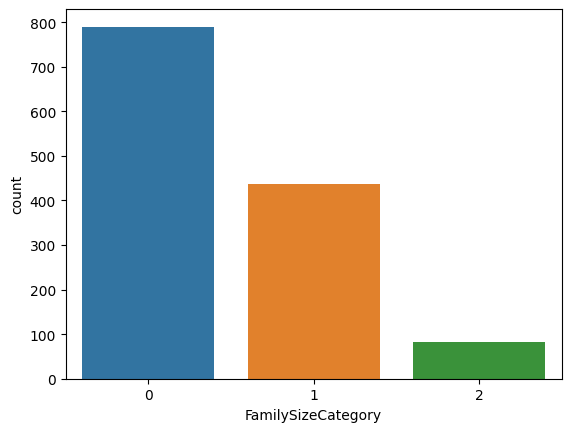

In [185]:
sns.barplot(x=full['FamilySizeCategory'].value_counts().index, y=full['FamilySizeCategory'].value_counts())

In [186]:
#Fill the missing value for age
full['Title'] = full['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}
full['Title'] = full['Title'].map(title_mapping)

In [187]:
numeric_columns = full.select_dtypes(include=['int64', 'float64']).columns
numeric_data = full[numeric_columns]
age_not_null_corr = numeric_data[numeric_data['Age'].notnull()].corr()
print(age_not_null_corr)

                    PassengerId  Survived    Pclass       Age     SibSp  \
PassengerId            1.000000  0.029340 -0.064097  0.028814 -0.050700   
Survived               0.029340  1.000000 -0.359653 -0.077221 -0.017358   
Pclass                -0.064097 -0.359653  1.000000 -0.408106  0.047221   
Age                    0.028814 -0.077221 -0.408106  1.000000 -0.243699   
SibSp                 -0.050700 -0.017358  0.047221 -0.243699  1.000000   
Parch                 -0.021096  0.093317  0.017224 -0.150917  0.374456   
Fare                   0.040097  0.341000 -0.735714  0.194624  0.289614   
Title                  0.012410  0.477351 -0.079458 -0.214301  0.372439   
FamilySize            -0.044024  0.042787  0.039602 -0.240229  0.844260   
FamilySizeCategory    -0.048093  0.106359 -0.074864 -0.174901  0.779310   

                       Parch      Fare     Title  FamilySize  \
PassengerId        -0.021096  0.040097  0.012410   -0.044024   
Survived            0.093317  0.341000  0.4773

In [191]:

# 删除目标变量中含有缺失值的样本
full_cleaned = full.dropna(subset=['Survived'])

# 选择特征和目标变量
X = full_cleaned[['Age', 'Parch', 'Pclass', 'SibSp', 'FamilySize', 'Title']]
y = full_cleaned['Survived']

# 使用 SimpleImputer 填充特征中的缺失值，这里使用均值填充
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# 划分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# 创建随机森林分类器并进行训练
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# 预测测试集的生存率
y_pred = rf_classifier.predict(X_test)

# 计算模型的准确率
accuracy = accuracy_score(y_test, y_pred)
print("accoracy score of random forest:", accuracy)

随机森林模型的准确率: 0.8044692737430168


In [195]:

# We want the best parameter
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

best_accuracy = 0
best_params = {}

for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            # random forest model
            rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
            
            # cross validation
            scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)
            accuracy = scores.mean()
            
            # using for loop to update the best one
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split
                }

# print best parameter and score
print("best parameter:", best_params)
print("best accuracy score:", best_accuracy)

best parameter: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10}
best accuracy score: 0.8187432286023835
